# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Aggregative-Clustering" data-toc-modified-id="Aggregative-Clustering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aggregative Clustering</a></div><div class="lev1 toc-item"><a href="#Robust-Regressions" data-toc-modified-id="Robust-Regressions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Robust Regressions</a></div><div class="lev1 toc-item"><a href="#Heatmap" data-toc-modified-id="Heatmap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Heatmap</a></div><div class="lev1 toc-item"><a href="#Making-the-Genetic-Graph" data-toc-modified-id="Making-the-Genetic-Graph-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Making the Genetic Graph</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as stm

# morgan
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

In [2]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

# create a dictionary of labels to translate
mutant_dict = {'b': 'egl-9',
               'c': 'hif-1',
               'e': 'rhy-1',
               'd': 'vhl-1',
               'g': 'fog-2'
              }

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)


In [4]:
thomas.filter_data(0, 0.1)

# labelling var:
genes = [genotype_mapping[x] for x in thomas.single_mutants]

Number of na genes: 232


# Aggregative Clustering

4674
The first 2 principal components explain >=90% of the data


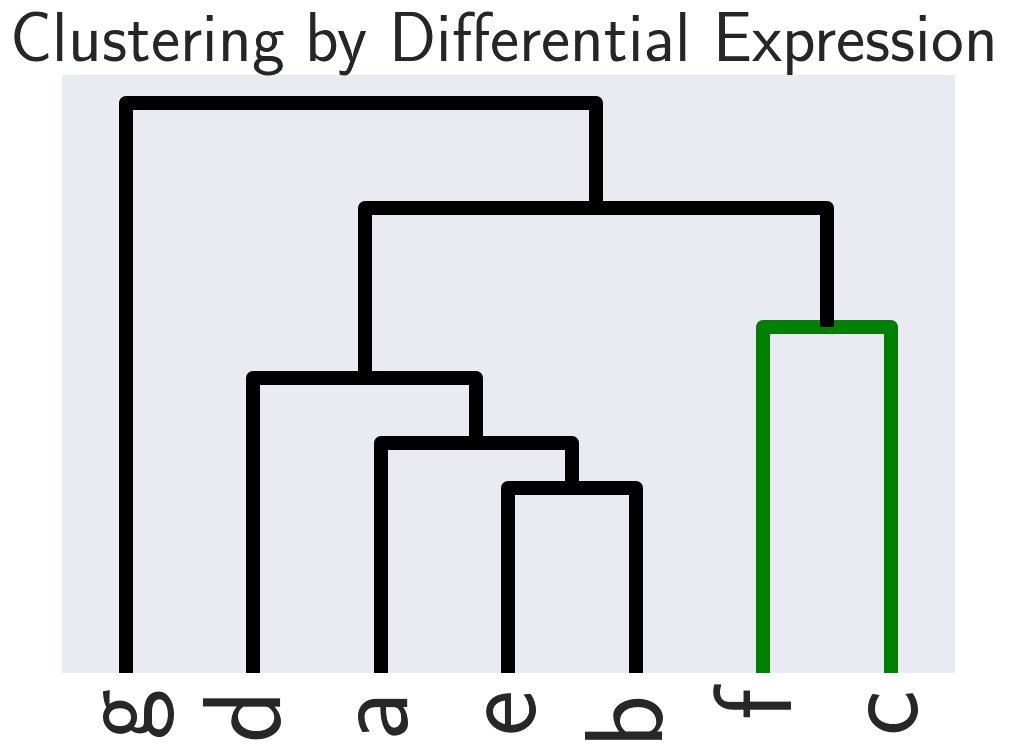

In [5]:
# find the set of all genes that are DE in any category
max_overlap = np.array([])
for df in thomas.beta_filtered.values():
    ind = df.qval < thomas.q
    if len(max_overlap) == 0:
        max_overlap = df[ind].target_id.values
    else:
        max_overlap = np.concatenate((max_overlap, 
                        df[ind].target_id.values))

max_overlap = max_overlap.tolist()
max_overlap = list(set(max_overlap))
print(len(max_overlap))

bvals = np.array([])
for df in thomas.beta_filtered.values():
    temp = df[df.target_id.isin(max_overlap)].b.values
    temp = (temp - temp.mean())/temp.std()
    if len(bvals) == 0:
        bvals = temp
    else:
        bvals = np.vstack((bvals, temp))

# Perform agglomerative clustering
sklearn_pca, n = genpy.pca(bvals)
model = hierarchy.linkage(sklearn_pca.transform(bvals), 'ward')
# extract the labels:
labels = list(thomas.beta_filtered.keys())

# rename the double mutant labels (i.e. instead of 'a' --> 'bd')
for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# Linewidth parameter, temporarily set to 7
plt.rcParams['lines.linewidth'] = 7

# set colors (black; blue)
hierarchy.set_link_color_palette(['k', 'g', 'b'])

# draw the dendrogram
hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=list(thomas.beta_filtered.keys()),
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    above_threshold_color='k'
)

# get the current axis
ax = plt.gca()

# add in the orange and green boxes
height = ax.get_ylim()[1]*.36

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())

title = 'Clustering by Differential Expression'
plt.title(title, fontsize=ft)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

# return linewidth to a reasonable setting
plt.rcParams['lines.linewidth'] = 2

In [6]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)
    
    # make the labels and title into paths
    effect = [path_effects.Normal()]
    plt.ylabel(ylabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.xlabel(xlabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.title(title,
              fontsize=titlesize).set_path_effects(effect)

    ax = plt.gca()
    # go through each xtick or ytick and make 
    # it a path if user specified to do so.
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects(effect)
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects(effect)

# Robust Regressions

In [7]:
def robust_regress(data):
    """A robust regression using a StudentT distribution instead of a Gaussian model."""
    with pm.Model() as model_robust:
        # set the model. pymc is nice because
        # it will automatically choose
        # appropriate priors for us once we 
        # specify our likelihood is StudentT
        family = pm.glm.families.StudentT()
        # specify we want a generalized linear
        # model with a Student T distribution
        pm.glm.glm('y ~ x', data, family=family)
        # find the MAP as a good starting point
        start = pm.find_MAP()
        # do the simulation and return the results
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

In [8]:
# a function to rank order the data
def find_rank(df):
    """A function to find the rank values of a variable."""
    # make a copy of the dataframe, then sort it inplace
    d = df.copy()
    d.sort_values('b', inplace=True)
    # make a rank vector and append it to the sorted dataframe
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    # sort by isoform name again and return the modified df
    d.sort_values('target_id', inplace=True)
    return d

In [9]:
# find inliers and outliers (see text description below)
def find_inliers(distribution, mean, trace):
    """A function to identify inliers and outliers in a distribution"""
    # find the outliers:
    sel = np.abs(distribution - mean)/(trace_robust.x.std() 
                 + trace_robust.Intercept.std()+ std) < 1.5
    
    # get the outliers and inliers
    distribution_inliers = distribution[sel]
    distribution_outliers = distribution[~sel]

    # get the gene names of the outliers
    inverse = distribution_outliers + \
                          intercept + ovx.r*slope
    outliers = ovy[ovy.r.isin(inverse)].target_id
    
    return distribution_inliers, distribution_outliers, outliers

In [10]:
# the genotypes to compare
letters = ['e', 'g']

# lambda index function:
lind = lambda x: (x.qval < 0.1)

# extract the dataframes from the morgan.hunt object
x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

# boolean logic to find the stat. sig. diff. 
ovx = x[lind(x)]
ovy = y[lind(y) & y.target_id.isin(ovx['target_id'])].copy()
ovx = x[lind(x) & x.target_id.isin(ovy['target_id'])].copy()

# append rank column:
ovx = find_rank(ovx)
ovy = find_rank(ovy)

In [11]:
# Take the data and put it into a
# dictionary to feed into robust regression
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())

# perform the simulation
trace_robust = robust_regress(data)

# normalize everything so that all points are centered around 0
intercept = trace_robust.Intercept.mean()
slope = trace_robust.x.mean()
distribution = ovy.r - intercept - ovx.r*slope

# find the mean and stdev of the distribution
mean = distribution.mean()
std = distribution.std()

# find inliers, and outliers
results = find_inliers(distribution, mean, trace_robust)
distribution_inliers, distribution_outliers, outliers = results

# get the y-coordinate of the inliers and outliers
yri = distribution_inliers + intercept + ovx.r*slope
yro = distribution_outliers + intercept + ovx.r*slope

# run a second regression on the outliers
data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r,
             y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)
slope2 = trace_robust2.x.mean()

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.4 sec

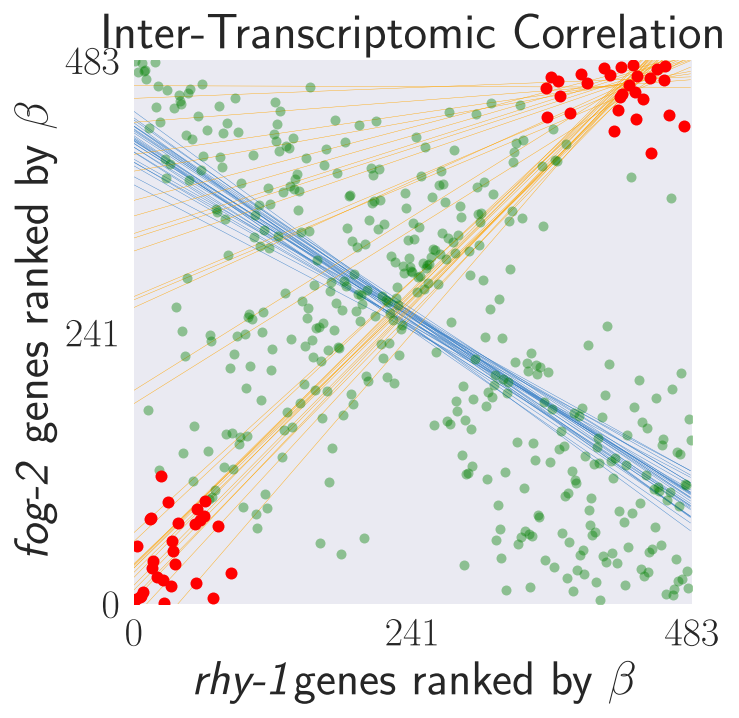

In [12]:
# draw a figure
plt.figure(figsize=(5, 5))

label = 'posterior predictive regression lines'
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label=label,
                                 color='#357EC7')

if slope2*slope < 0:
    pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                     label=label,
                                     color='#FFA500')

# plot the data. Inliers are plotted as 
#large green dots, outliers as small red dots
plt.plot(ovx.r, yri, 'go', ms = 5, alpha=0.4)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 6)

# prettify plot
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
plt.xticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
pathify('Inter-Transcriptomic Correlation', 
        genotype_mapping[letters[0]] + r'genes ranked by $\beta$', 
        genotype_mapping[letters[1]] + r' genes ranked by $\beta$',
        labelsize=24)
comp = letters[0] + letters[1]
plt.savefig('../output/multiple_modes_{0}.pdf'.format(comp))

In [13]:
print(
"""The average slope of the robust regression was {0:.2g}""".format(slope)
)

The average slope of the robust regression was -0.65


# Heatmap

In [14]:
# Define a plotting function to plot only a triangular heat map
def tri_plot(matrix, xlabels, ylabels=[]):
    """Given a matrix, draw a triangle plot."""
    # Minimum and maximum for colormap
    vmin= matrix.min().min()
    vmax= np.max(matrix).max()

    # if user didn't specify xlabels, assume ylabels 
    # are the same as xlabels
    if len(ylabels) == 0:
        ylabels = xlabels

    # make the lower triangle of the matrix,
    # since we are only dealing with 
    # symmetric matrices. Also, remove the diagonal
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True

    # draw and adjust xtick size
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels,
                         yticklabels=ylabels, cmap='RdBu',
                         mask=mask, square=True, vmin=vmin,
                         vmax=vmax)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

In [15]:
barbara = morgan.mcclintock('bayesian', thomas, True)


starting comparison of e, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of e, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2001 of 2000 complete in 2.0 sec
starting comparison of e, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of e, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of g, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of g, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

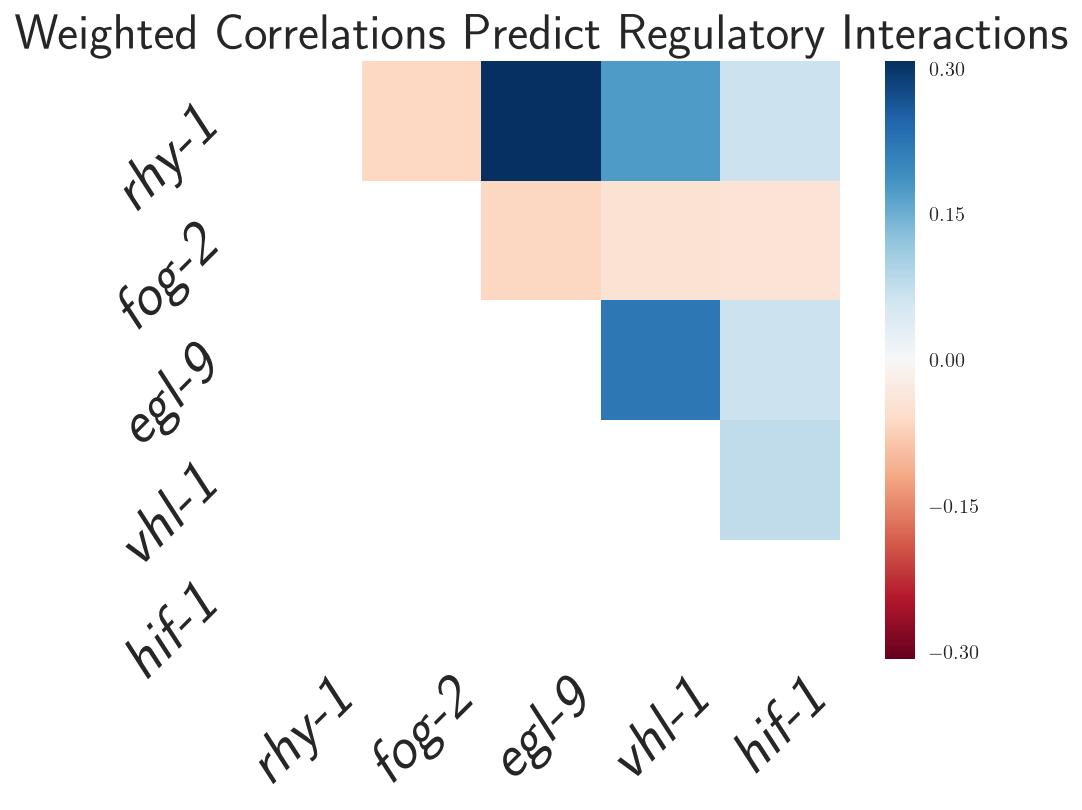

In [16]:
mat = barbara.robust_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
pathify('Weighted Correlations Predict Regulatory Interactions',
        '', '')
plt.savefig('../output/bayes_primary_single_mutants.pdf',
            bbox_inches='tight')

# Making the Genetic Graph

In [19]:
def make_genetic_graph(robust_slope, id_vars='corr_with',
                       var_name='geno1', value_name='correl',
                       **kwargs):
    """A function to generate a graph of genetic relationships."""
    w = kwargs.pop('w', 2)
    
    # initialize an empty graph:
    G=nx.Graph()
    df = pd.melt(barbara.robust_slope, id_vars='corr_with', var_name='geno1',
                value_name='correl')
    df = df[df.correl != 0]

    # add edges between nodes
    for g1 in df.geno1.unique():
        for g2 in df.corr_with.unique():
            if g1 == g2:
                continue

            # extract the correlation coefficient
            sel = (df.geno1 == g1) & (df.corr_with == g2)
            if len(df[sel]):
                r = df[sel].correl.values[0]
            # only add an edge if a correlation coefficient exists:
            if r:
                # add the edge
                G.add_edge(mutant_dict[g1],
                           mutant_dict[g2], weight=r)

    # parameterize the edge and width and color of the graphs
    elarge = [(u,v) for (u,v,d) in G.edges(data=True)]
    # set the width 
    # width will be proportional to the log(correl/smallest_abs_corr)
    width = [w*np.log(
                    np.abs(
                           d['weight']/df.correl.abs().min()
                          )  # abs
                    )  # log
            for (u,v,d) in G.edges(data=True)] # width
    # extract the weights (keep these exact!)
    weights = [d['weight'] for (u,v,d) in G.edges(data=True)]

    return G, width, weights, elarge

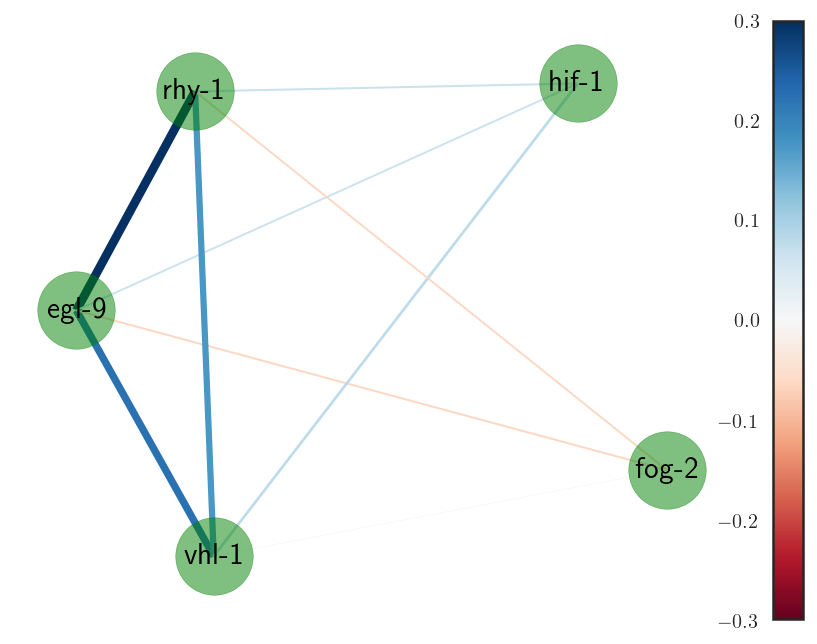

In [20]:
# make the graph:
G, width, weights, elarge = make_genetic_graph(barbara.robust_slope, w=2.2)

# paint the canvas:
with sns.axes_style('white'):
    fig, ax = plt.subplots()
    pos=nx.spring_layout(G)  # positions for all nodes

    # draw the nodes:
    nx.draw_networkx_nodes(G, pos, node_size=1500,
                           node_color='g', alpha=.5)

    # draw the edges:
    edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                                   width=width, edge_color=weights,
                                   edge_cmap=plt.cm.RdBu,
                                   edge_vmin=-.3, 
                                   edge_vmax=.3)

    # add the labels:
    nx.draw_networkx_labels(G, pos, font_size=15,
                            font_family='sans-serif')

    # add a colorbar:
    fig.colorbar(edges)
    sns.despine()
    sns.despine(left=True, bottom=True)
    # de-tick and save
    plt.xticks([])
    plt.yticks([])
    plt.savefig("../output/weighted_graph.pdf") # save as png
    plt.show() # display